In [15]:
# Enable Float64 for more stable matrix inversions.
from jax import config

config.update("jax_enable_x64", True)

from dataclasses import dataclass
from typing import Dict

from jax import jit
import jax.numpy as jnp
import jax.random as jr
from jaxtyping import (
    Array,
    Float,
    install_import_hook,
)
import matplotlib.pyplot as plt
import numpy as np
from simple_pytree import static_field
import tensorflow_probability.substrates.jax as tfp

with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx
    from gpjax.base.param import param_field

key = jr.key(123)
tfb = tfp.bijectors
plt.style.use(
    "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
)
cols = plt.rcParams["axes.prop_cycle"].by_key()["color"]

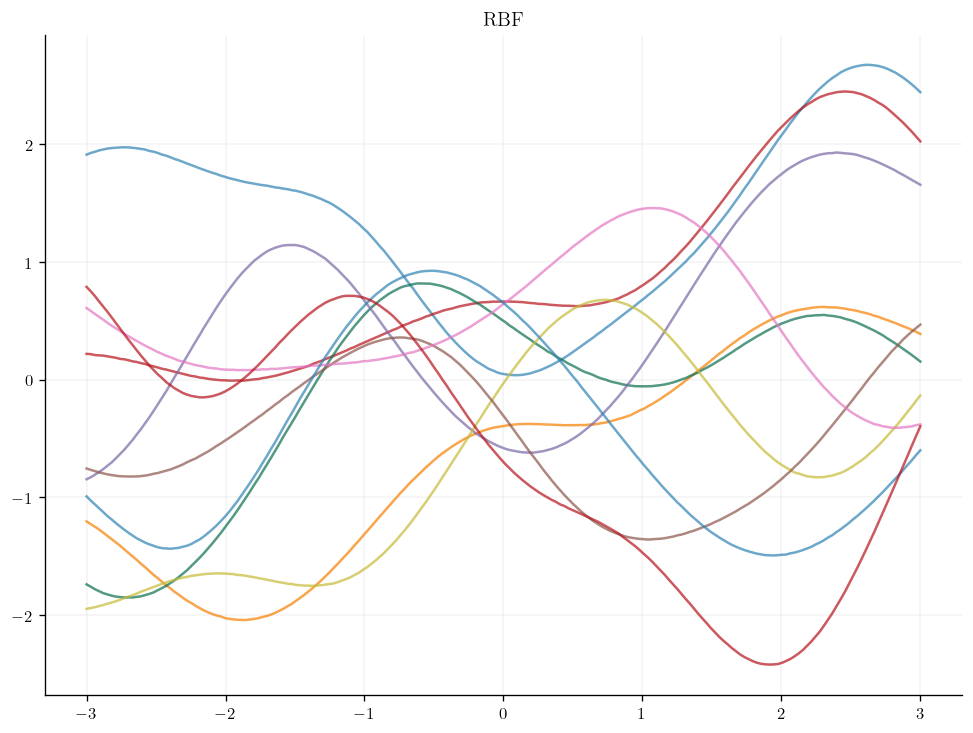

In [21]:
x = jnp.linspace(-3.0, 3.0, num=200).reshape(-1, 1)
meanf = gpx.mean_functions.Zero()
rbf_kernel = gpx.kernels.RBF()
fig, ax = plt.subplots(figsize=(8, 6))
prior = gpx.gps.Prior(mean_function=meanf, kernel=rbf_kernel)
rv = prior(x)
y = rv.sample(seed=key, sample_shape=(10,))
ax.plot(x, y.T, alpha=0.7)
ax.set_title(rbf_kernel.name)
plt.show()

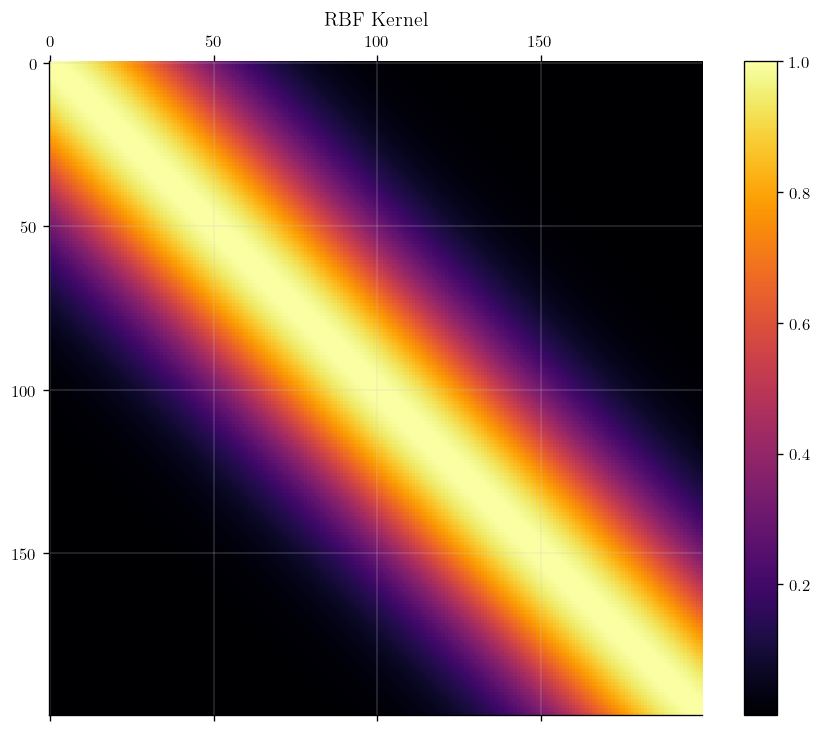

In [33]:
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(rbf_kernel.gram(x).to_dense())
fig.colorbar(cax)
ax.set_title('RBF Kernel')

plt.show()

Modifying parameter limits of RBF kernel now

In [19]:
from dataclasses import dataclass

from beartype.typing import Union
import jax.numpy as jnp
from jaxtyping import Float
import tensorflow_probability.substrates.jax.bijectors as tfb
import tensorflow_probability.substrates.jax.distributions as tfd

from gpjax.base import param_field
from gpjax.kernels.base import AbstractKernel
from gpjax.kernels.stationary.utils import squared_distance
from gpjax.typing import (
    Array,
    ScalarFloat,
)

In [57]:
@dataclass
class RBF_new(AbstractKernel):
    r"""The Radial Basis Function (RBF) kernel."""


    l_constraint = tfb.Chain([tfb.Shift(0.5), tfb.Scale(10.0)])
    initial_l = l_constraint.inverse(2.5 * jnp.ones((1,1),dtype=jnp.float32))
    lengthscale: Union[ScalarFloat, Float[Array, " D"]] = param_field(initial_l, bijector=tfb.Invert(l_constraint))

    variance: ScalarFloat = param_field(jnp.array(1.0), bijector=tfb.Softplus())
    name: str = "RBF Modified"

    def __call__(self, x: Float[Array, " D"], y: Float[Array, " D"]) -> ScalarFloat:
        x = self.slice_input(x) / self.lengthscale
        y = self.slice_input(y) / self.lengthscale
        K = self.variance * jnp.exp(-0.5 * squared_distance(x, y))
        return K.squeeze()

    @property
    def spectral_density(self) -> tfd.Normal:
        return tfd.Normal(loc=0.0, scale=1.0)

In [72]:
# With init method
@dataclass
class RBF_new(AbstractKernel):
    r"""The Radial Basis Function (RBF) kernel."""

    l_constraint = tfb.Chain([tfb.Shift(0.5), tfb.Scale(10.0)])
    initial_l = l_constraint.inverse(2.5 * jnp.ones((1,1),dtype=jnp.float32))
    lengthscale: Union[ScalarFloat, Float[Array, " D"]] = param_field(initial_l, bijector=tfb.Invert(l_constraint))

    variance: ScalarFloat = param_field(jnp.array(1.0), bijector=tfb.Softplus())
    name: str = "RBF Modified"

    def __post_init__(self):
        super().__init__()

        self.lengthscale = self.lengthscale
        self.variance = param_field(jnp.array(1.0), bijector=tfb.Softplus())
        self.name = "RBF Modified"

    def __call__(self, x: Float[Array, " D"], y: Float[Array, " D"]) -> ScalarFloat:
        x = self.slice_input(x) / self.lengthscale
        y = self.slice_input(y) / self.lengthscale
        K = self.variance * jnp.exp(-0.5 * squared_distance(x, y))
        return K.squeeze()

    @property
    def spectral_density(self) -> tfd.Normal:
        return tfd.Normal(loc=0.0, scale=1.0)

TypeError: unsupported operand type(s) for *: 'Field' and 'BatchTracer'

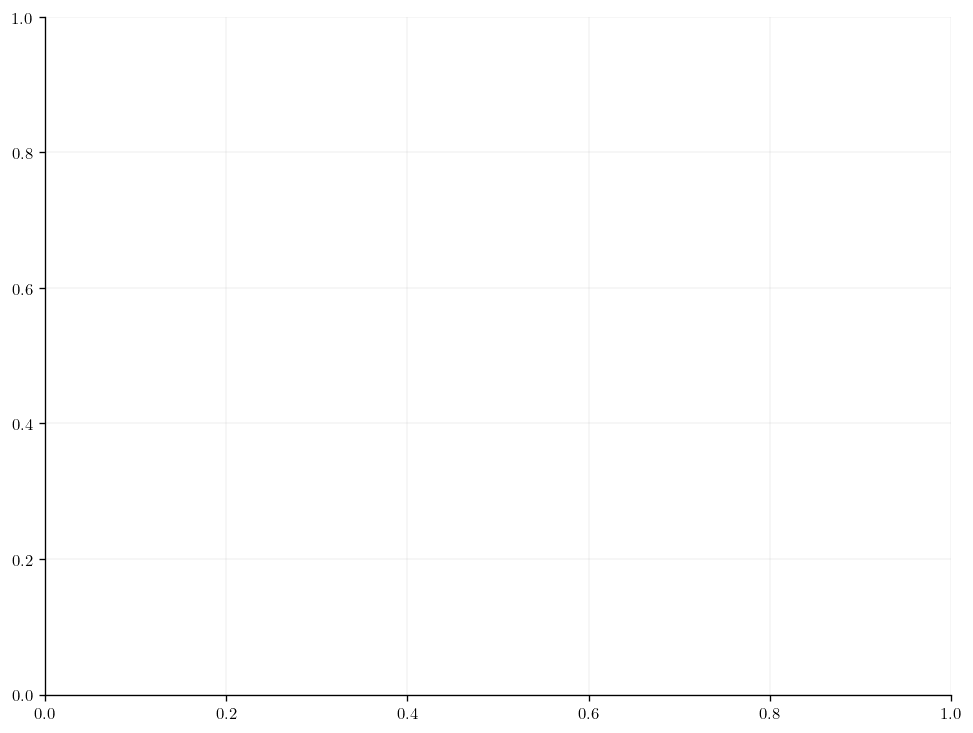

In [73]:
x = jnp.linspace(-3.0, 3.0, num=200).reshape(-1, 1)
meanf = gpx.mean_functions.Zero()
rbf_new_kernel = RBF_new()
fig, ax = plt.subplots(figsize=(8, 6))
prior = gpx.gps.Prior(mean_function=meanf, kernel=rbf_new_kernel)
rv = prior(x)
y = rv.sample(seed=key, sample_shape=(10,))
ax.plot(x, y.T, alpha=0.7)
ax.set_title(rbf_new_kernel.name)
plt.show()

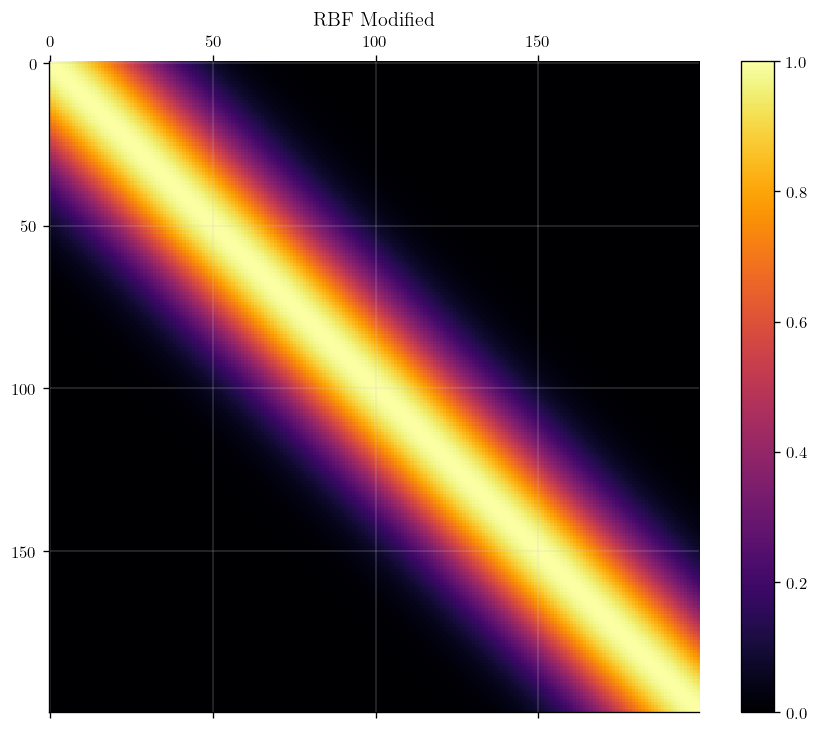

In [42]:
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(rbf_new_kernel.gram(x).to_dense())
fig.colorbar(cax)
ax.set_title(rbf_new_kernel.name)

plt.show()